In [1]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re

Using TensorFlow backend.


In [3]:
songs = pd.read_csv('data/drake-songs.csv')

In [4]:
text = ''

for index, row in songs['lyrics'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
    
len(text)

367372

In [5]:
import re

tokens = re.findall(r"[a-z'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 28


In [6]:
chars

[' ',
 "'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:

maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 122444


In [8]:


x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [9]:

print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

Build model...


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [11]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [12]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [13]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
122444/122444 [==============================] - 45s 370us/step - loss: 1.8640
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " used to always stay at home be a good g"
 used to always stay at home be a good got a so your still i got me i can't wan start i got the goin' i can't never shit the shit i got me i got me i can't i got me they want i still the mace the been i don't see still on the say i got a go take the beat you do the go the same they still on the go to sear i can start i was the sear i got me like me a go the see show that i got a say they now they want the the been i can on the back i wa
----- diversity: 0.5
----- Generating with seed: " used to always stay at home be a good g"
 used to always stay at home be a good go hard go ere i can't xave a corn and i still me they on with of the gont i was go hare in they loving we now to live they all i know who we got and i got a say this probe word on the tay a pare the face your

e been around it you only want what's rew to rest my days i'm sound the bottom now you know i'mma still the waits it the stunt and did i still the same i'mma be man are you don't look i stip it i'mma started to me stone so the get the way i got a bottle for me every city and you do the way you bet the both no now you know it out the cash then i got a be a minsing me what i been prace this is the money want you ask my cause i just had to
Epoch 8/10
122444/122444 [==============================] - 44s 356us/step - loss: 1.2552
----- Generating text after Epoch: 7
----- diversity: 0.2
----- Generating with seed: " into something can't just leave it off "
 into something can't just leave it off to man the money i got man i don't like the clood on the same i got man i got me the bottom now i can tell me they like the bottom no no no now i got man i don't want the bottom now i know you got me the bottom now i don't want the thing i want the connect i got me they like the bottom no no no now 

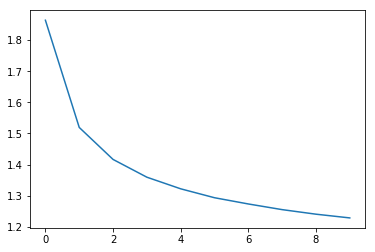

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [15]:
def generate_output():
    generated = ''
    usr_input = input("Write the beginning of your poem, the Drake machine will complete it. Your input is: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [16]:
Tx = 40
generate_output()

Write the beginning of your poem, the Drake machine will complete it. Your input is: hello my name is mayur


Here is your poem: 

hello my name is mayurin' the way in the same i don't know they gon' think i don't know they know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you got the bandwaybod and she said i want the shit i don't know you say it i got me and i got the man on the bottom now we're to the club i don't know they know 

In [20]:
import utils

In [ ]:
utils.save_model_weights(model)